# **FINAL PROJECT STAGE 1**
**DATA SCIENCE BATCH 53 - DATA MARK**

*   M. Haris Maulana Koliq .A
*   Meikanur Sidiq
*   Khamsah Akbar
*   Ramadhian Ekaputra

# 📊 Employee Churn Analysis and Prediction

Proyek ini bertujuan untuk menganalisis faktor-faktor yang memengaruhi churn (perpindahan atau keluar dari perusahaan) karyawan dan membangun model prediktif untuk mengidentifikasi karyawan yang berisiko churn. Proses ini mencakup:
- Eksplorasi data (EDA)
- Pembersihan dan rekayasa fitur
- Pembuatan model prediksi (Logistic Regression, Random Forest, XGBoost)
- Evaluasi model dan interpretasi

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/employee_churn_prediction_updated.csv')

In [4]:
df.sample(5)

,employee_id,age,gender,education,experience_years,monthly_target,target_achievement,working_hours_per_week,overtime_hours_per_week,salary,commission_rate,job_satisfaction,work_location,manager_support_score,company_tenure_years,churn,marital_status,distance_to_office_km,churn_period
787,788,40,Male,Bachelor,7,101,0.72,52,4,6726904,0.03,4,Urban,2,4.7,0,Married,40,Stayed
491,492,24,Male,High School,2,112,0.60,40,10,4972613,0.09,4,Urban,4,1.6,1,Single,38,3 Months
963,964,32,Male,Diploma,3,133,0.43,48,18,5718181,0.08,4,Urban,1,2.6,1,Single,41,1 Month
16,17,42,Female,High School,7,75,0.54,51,2,5768654,0.04,3,Urban,4,2.4,0,Married,15,Stayed
876,877,26,Male,Diploma,3,97,0.96,40,2,4967582,0.05,3,Urban,2,4.4,0,Married,17,Stayed


## 📊 Exploratory Data Analysis (EDA)

### 📌 Descriptive Statistics

In [5]:
# Dimensi dan info
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              1000 non-null   int64  
 1   age                      1000 non-null   int64  
 2   gender                   1000 non-null   object 
 3   education                1000 non-null   object 
 4   experience_years         1000 non-null   int64  
 5   monthly_target           1000 non-null   int64  
 6   target_achievement       1000 non-null   float64
 7   working_hours_per_week   1000 non-null   int64  
 8   overtime_hours_per_week  1000 non-null   int64  
 9   salary                   1000 non-null   int64  
 10  commission_rate          1000 non-null   float64
 11  job_satisfaction         1000 non-null   int64  
 12  work_location            1000 non-null   object 
 13  manager_support_score    1000 non-null   int64  
 14  company_tenure_years     

((1000, 19), None)

- Total Baris: 1000
- Total Kolom: 19
- Tidak Ada Missing Values (Semua kolom memiliki 1000 nilai non-null)
- Tidak perlu dilakukan imputasi

Jenis Data:
- Numerik: age, experience_years, monthly_target, target_achievement, working_hours_per_week, overtime_hours_per_week, salary, commission_rate, job_satisfaction, manager_support_score, company_tenure_years, distance_to_office_km

- Kategori: gender, education, work_location, marital_status, churn_period

- Biner: churn (0 = Tidak Berhenti, 1 = Berhenti)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,1000.0,5.005000e+02,2.888194e+02,1.00,250.75,500.50,750.25,1000.0
age,1000.0,3.284500e+01,6.854046e+00,22.00,27.00,33.00,39.00,44.0
experience_years,1000.0,4.495000e+00,2.890732e+00,0.00,2.00,5.00,7.00,9.0
monthly_target,1000.0,1.258770e+02,4.389575e+01,50.00,86.75,127.50,164.00,199.0
target_achievement,1000.0,7.918800e-01,2.287199e-01,0.40,0.59,0.79,0.99,1.2
working_hours_per_week,1000.0,5.410200e+01,8.721907e+00,40.00,46.00,54.00,62.00,69.0
overtime_hours_per_week,1000.0,9.508000e+00,5.739066e+00,0.00,5.00,9.50,15.00,19.0
salary,1000.0,5.487914e+06,1.436482e+06,3000037.00,4258969.50,5471270.00,6727894.00,7999712.0
commission_rate,1000.0,5.883000e-02,2.327817e-02,0.02,0.04,0.06,0.08,0.1
job_satisfaction,1000.0,2.524000e+00,1.125474e+00,1.00,2.00,3.00,4.00,4.0


- Usia Karyawan (age):
Rentang: 22–44 tahun
Rata-rata: ~32,8 tahun
- Pengalaman Kerja (experience_years):
Rata-rata: ~4,5 tahun
Maksimum: 9 tahun
- Target Bulanan (monthly_target):
Rata-rata: ~126 (unit/kinerja)
Maksimum: 199
- Tingkat Pencapaian Target (target_achievement):
Rata-rata pencapaian: ~79%
Maksimum pencapaian: 120%
- Jam Kerja Mingguan (working_hours_per_week):
Rata-rata: ~54 jam/minggu
Maksimum: 69 jam/minggu
- Gaji Karyawan (salary):
Rata-rata: ~5,49 juta
Rentang: ~3 juta hingga ~8 juta rupiah
- Job Satisfaction & Manager Support:
Skala: 1–4
Rata-rata: ~2,5 (sedang)
- Jarak ke Kantor (distance_to_office_km):
Rata-rata: ~24 km
Rentang: 1–49 km
- Churn Rate (churn):
Rata-rata churn: ~62,9% dari total karyawan.


In [7]:
df.describe(include='object')

,gender,education,work_location,marital_status,churn_period
count,1000,1000,1000,1000,1000
unique,2,3,3,2,4
top,Male,Diploma,Urban,Single,Stayed
freq,703,404,500,606,371


- **Gender**: Mayoritas **laki-laki (703 dari 1000)**
- **Tingkat Pendidikan**: Mayoritas **Diploma (404 dari 1000)**
- **Lokasi Kerja**: Setengah karyawan berada di **Urban (500 dari 1000)**
- **Status Pernikahan**: Mayoritas **Single (606 dari 1000)**
- **Churn Period**: Paling banyak **Stayed (371 dari 1000)**

### 🧹 Missing Values Cleansing

In [8]:
df.isnull().sum()

,0
employee_id,0
age,0
gender,0
education,0
experience_years,0
monthly_target,0
target_achievement,0
working_hours_per_week,0
overtime_hours_per_week,0
salary,0


In [9]:
# --- 1. CEK MISSING VALUES ---
print("🔍 [1] CEK MISSING VALUES")
missing = df.isnull().sum()
missing_total = missing.sum()

if missing_total == 0:
    print("✅ Tidak ada missing values. Data aman.")
else:
    print("⚠️ Terdapat missing values:")
    print(missing[missing > 0])
    print("\n💡 Saran: Imputasi nilai yang hilang, misalnya dengan mean/median (numerik) atau modus (kategorikal).")

🔍 [1] CEK MISSING VALUES
✅ Tidak ada missing values. Data aman.


#### 🔍 Duplicate Cleansing

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
# --- 2. CEK DUPLIKAT ---
print("\n🔍 [2] CEK DUPLIKAT")
duplicates = df.duplicated().sum()

if duplicates == 0:
    print("✅ Tidak ada data duplikat. Data aman.")
else:
    print(f"⚠️ Terdapat {duplicates} baris duplikat.")
    print("💡 Saran: Gunakan `df.drop_duplicates()` untuk menghapus baris yang duplikat.")


🔍 [2] CEK DUPLIKAT
✅ Tidak ada data duplikat. Data aman.


### 🧼 Outlier Cleansing

In [12]:
# Menghapus outlier menggunakan IQR method
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Jumlah data setelah outlier cleansing: {df_cleaned.shape[0]} dari {df.shape[0]} baris awal")

Jumlah data setelah outlier cleansing: 1000 dari 1000 baris awal


In [13]:
print("\n🔍 [3] CEK OUTLIER (Metode IQR)")

def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
outlier_report = {}

for col in numeric_cols:
    outliers = detect_outliers_iqr(df[col])
    count_outliers = len(outliers)
    outlier_report[col] = count_outliers

# Tampilkan hasil outlier
outlier_df = pd.DataFrame.from_dict(outlier_report, orient='index', columns=['Jumlah Outlier'])
print(outlier_df)

# Interpretasi
total_outliers = outlier_df['Jumlah Outlier'].sum()

if total_outliers == 0:
    print("\n✅ Tidak ditemukan outlier yang signifikan. Data aman.")
else:
    print(f"\n⚠️ Terdapat {total_outliers} nilai outlier dalam data.")
    print("💡 Saran:")
    print("- Analisis apakah outlier tersebut valid secara bisnis (contoh: gaji tinggi bisa wajar).")
    print("- Jika tidak valid, pertimbangkan: trimming, winsorizing, atau transformasi log/Box-Cox.")


🔍 [3] CEK OUTLIER (Metode IQR)
                         Jumlah Outlier
employee_id                           0
age                                   0
experience_years                      0
monthly_target                        0
target_achievement                    0
working_hours_per_week                0
overtime_hours_per_week               0
salary                                0
commission_rate                       0
job_satisfaction                      0
manager_support_score                 0
company_tenure_years                  0
churn                                 0
distance_to_office_km                 0

✅ Tidak ditemukan outlier yang signifikan. Data aman.


Menggunakan metode IQR (Interquartile Range):

Tidak ditemukan outlier di kolom numerik manapun. Data bersih dari nilai ekstrem yang mencurigakan.

### 📌 Dataset Visualization

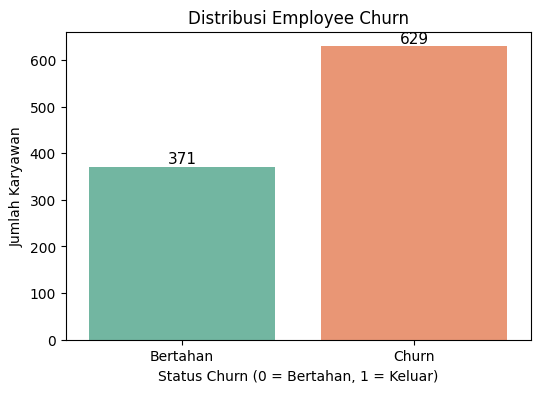

In [14]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='churn', data=df, palette='Set2')
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.title("Distribusi Employee Churn")
plt.xlabel("Status Churn (0 = Bertahan, 1 = Keluar)")
plt.ylabel("Jumlah Karyawan")
plt.xticks([0, 1], ['Bertahan', 'Churn'])
plt.show()

### 🔍 Distribusi Churn

Visualisasi di atas menunjukkan distribusi target variabel `churn`:

- **0 (Tidak churn):** 371 karyawan  
- **1 (Churn):** 629 karyawan  


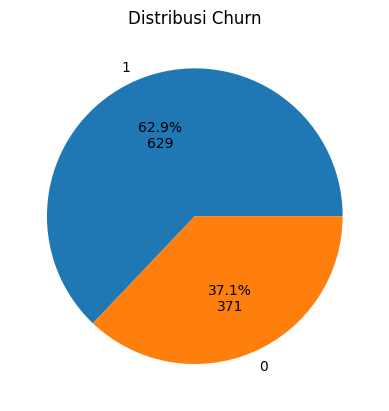

In [15]:
# Churn Pie Chart
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, df['churn'].value_counts().values.sum()*x/100)

plt.pie(df['churn'].value_counts().values, labels=df['churn'].value_counts().index, autopct=fmt)
plt.title("Distribusi Churn")
plt.show()

### 📊 Distribusi Churn (Pie Chart)

Sebanyak **62.9%** dari total **1000 karyawan** di perusahaan terindikasi mengalami **churn** (keluar dari perusahaan), sedangkan **37.1%** tetap bertahan.

### 📌 Insight:
- Angka churn yang tinggi menunjukkan adanya masalah serius dalam **retensi karyawan**.


Sebanyak 62.9% dari total 1000 karyawan churn di perusahaan yang harus dianalisis lebih lanjut mengapa hal ini dapat terjadi.

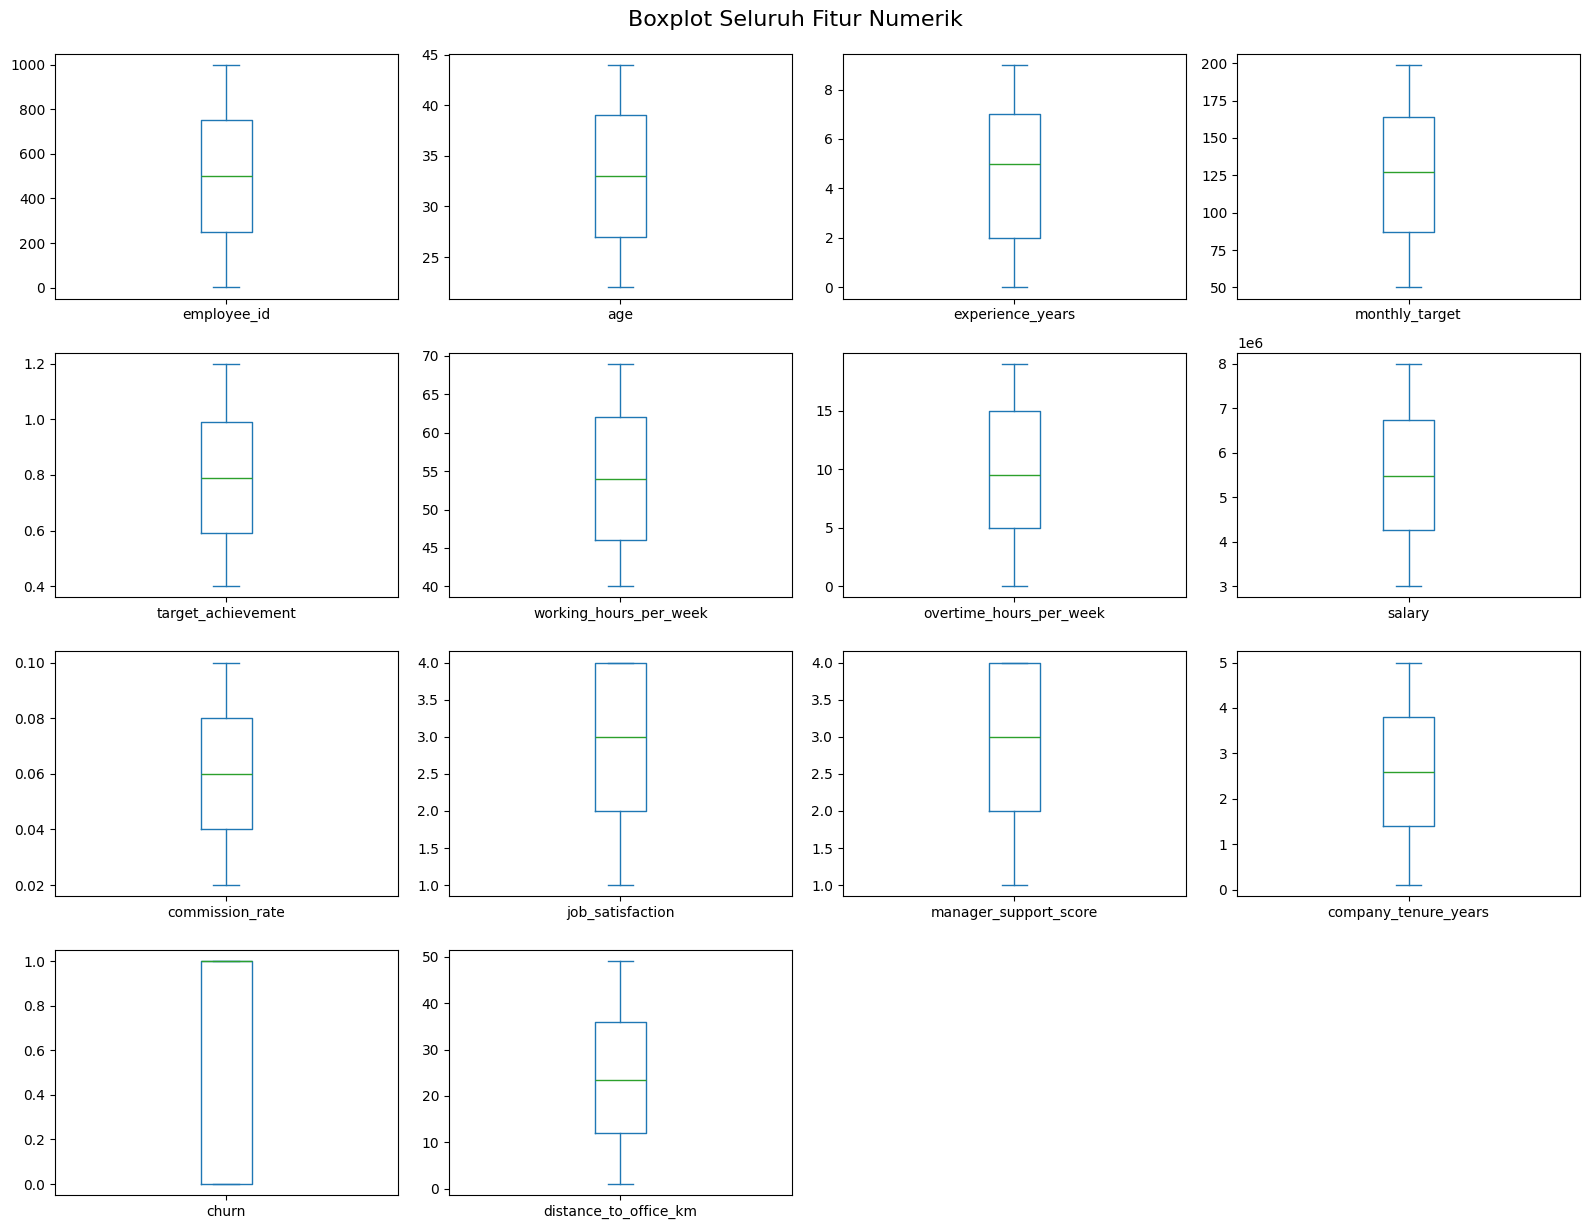

In [16]:
numerics = df.select_dtypes(include=np.number).columns

df[numerics].plot(kind='box', subplots=True, layout=(4, 4), figsize=(16, 12), sharex=False, sharey=False)
plt.tight_layout()
plt.suptitle("Boxplot Seluruh Fitur Numerik", fontsize=16, y=1.02)
plt.show()

### 📊 Insight Penting:
- **Sebagian besar fitur** memiliki distribusi normal dengan sebaran yang baik.
- **Fitur hasil rekayasa**:
  - `total_hours_per_week`: Terdistribusi merata, tidak ada outlier mencolok.
  - `target_ratio`: Terdapat beberapa nilai outlier di atas batas atas, namun masih dalam rentang yang masuk akal secara bisnis (rasio target bisa sangat tinggi bila target kecil namun pencapaian besar).
- Fitur asli seperti `salary`, `working_hours_per_week`, dan `distance_to_office_km` menunjukkan sebaran simetris tanpa nilai ekstrem.



### 📈 Univariate Analysis: Numerical Features

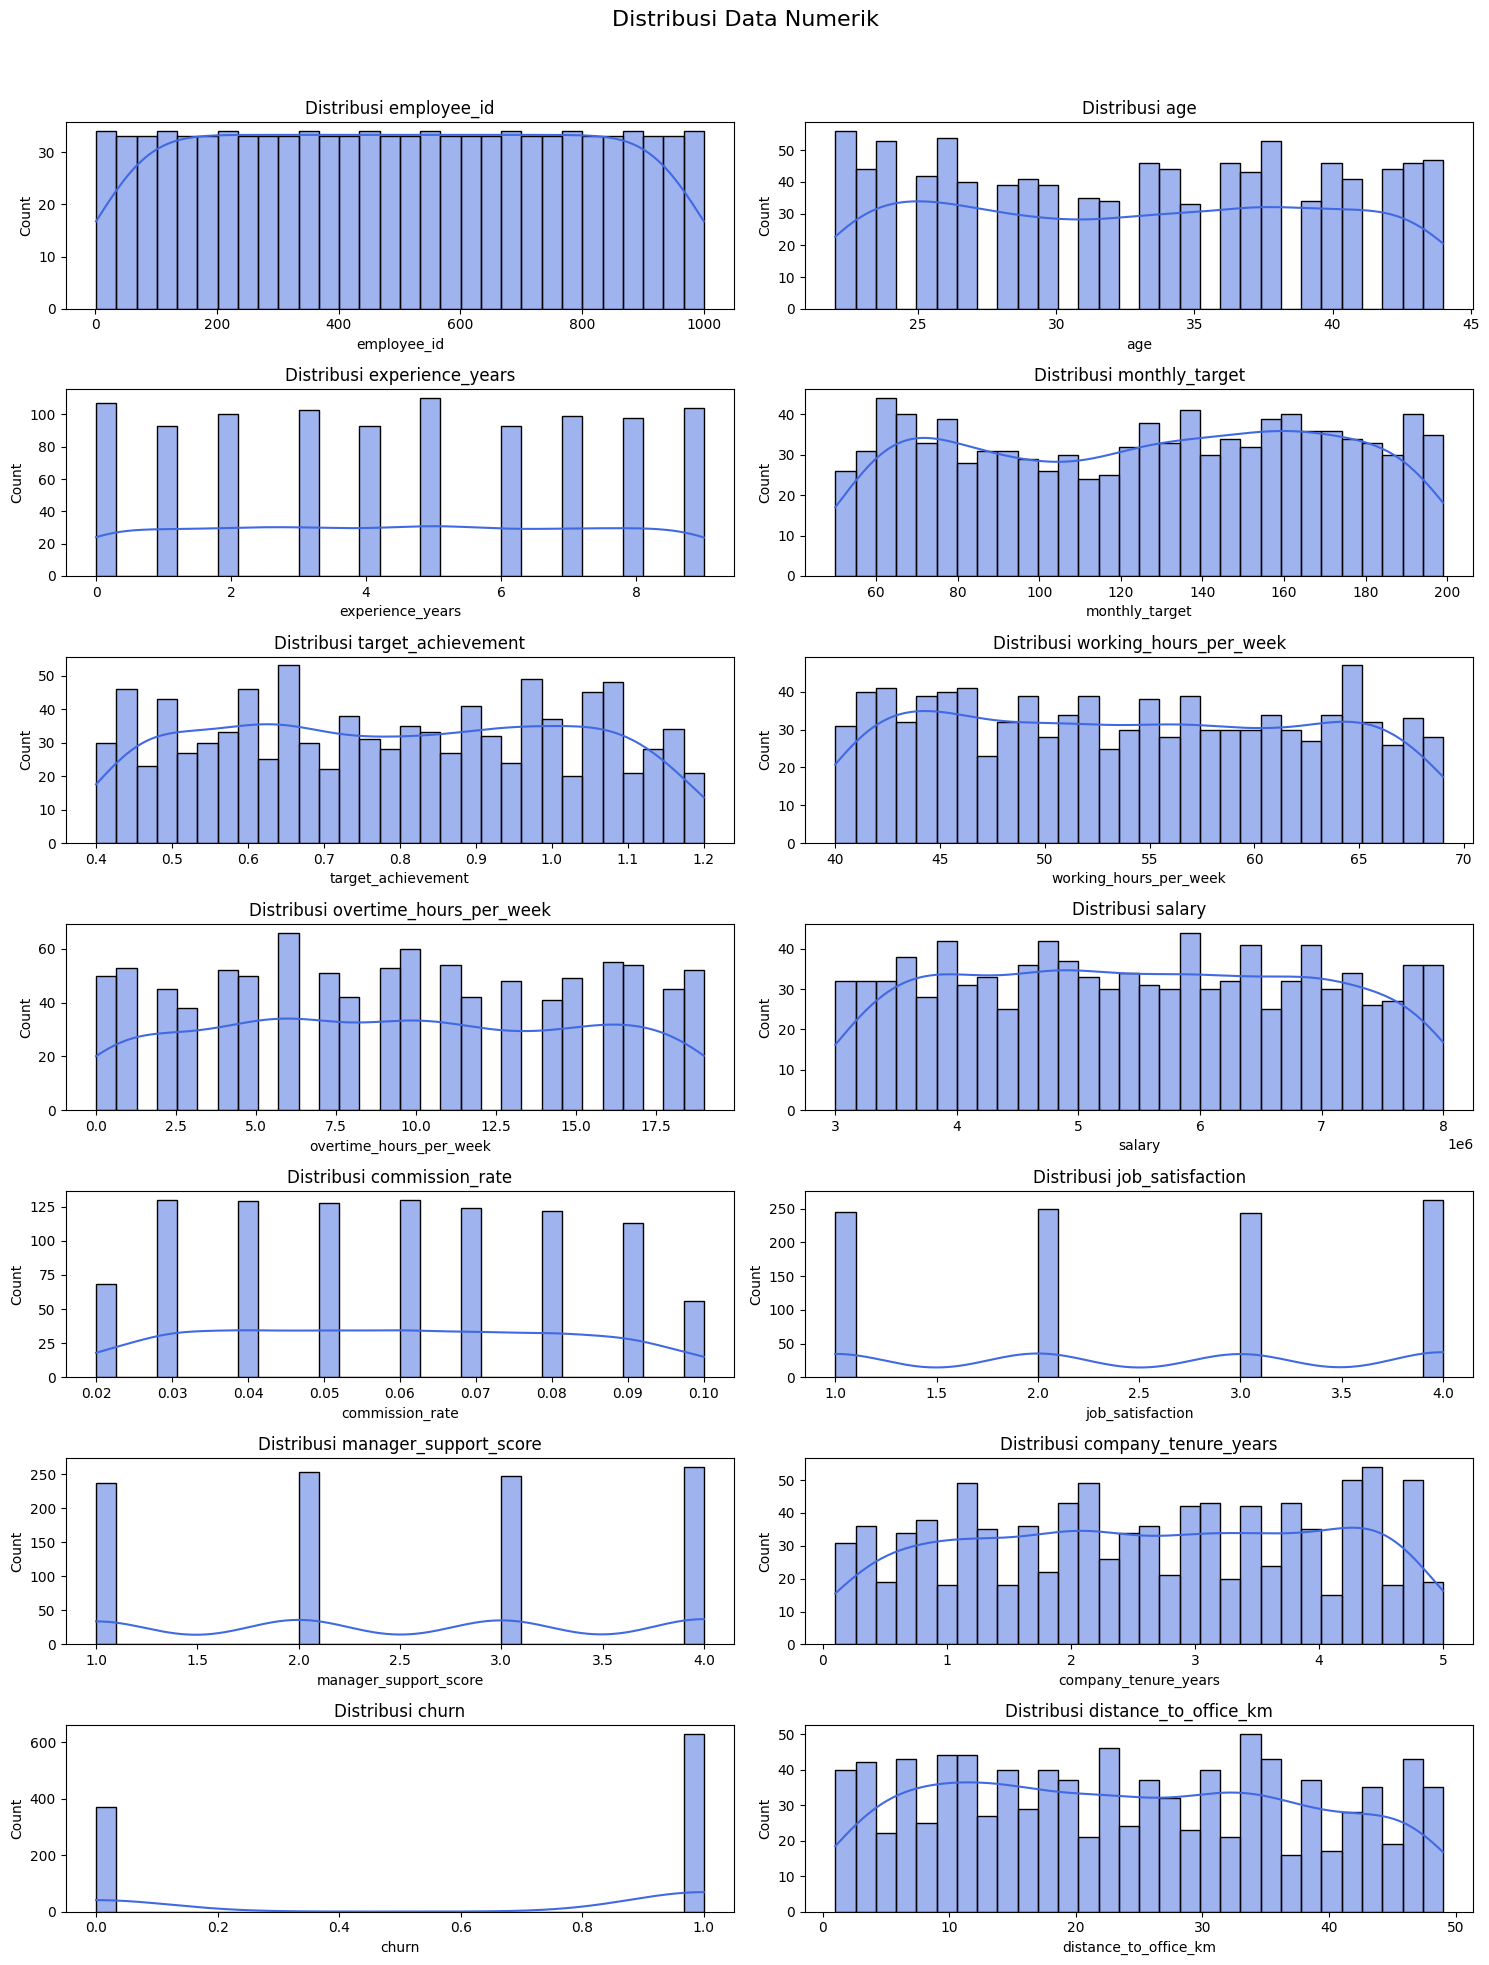

In [17]:
## Visualisasi distribusi variabel numerik
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

fig, axes = plt.subplots(nrows=len(num_cols)//2, ncols=2, figsize=(15, 20))
fig.suptitle("Distribusi Data Numerik", fontsize=16)

for i, col in enumerate(num_cols):
    ax = axes[i // 2, i % 2]
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color="royalblue")
    ax.set_title(f"Distribusi {col}", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- **Distribusi usia & pengalaman kerja** cukup normal, tetapi beberapa karyawan memiliki **0 tahun pengalaman** (perlu dicek lebih lanjut).
- **Target bulanan dan pencapaian target** menunjukkan distribusi yang miring, beberapa karyawan memiliki pencapaian lebih dari 1.2x target.
- **Jam kerja dan lembur** menunjukkan mayoritas karyawan bekerja **40-69 jam per minggu**.
- **Gaji** memiliki distribusi yang luas, beberapa karyawan mendapat gaji **lebih dari 7 juta** (indikasi outlier).
- **Jarak ke kantor** menunjukkan distribusi lebar, ada yang bekerja dari **1 km hingga 49 km**.

Sebagian besar distribusi terlihat normal atau sedikit right-skewed (gaji, jam kerja).

Ini memberikan indikasi awal yang bagus untuk pemodelan atau transformasi data jika dibutuhkan.

### 📊 Univariate Analysis: Categorical Features

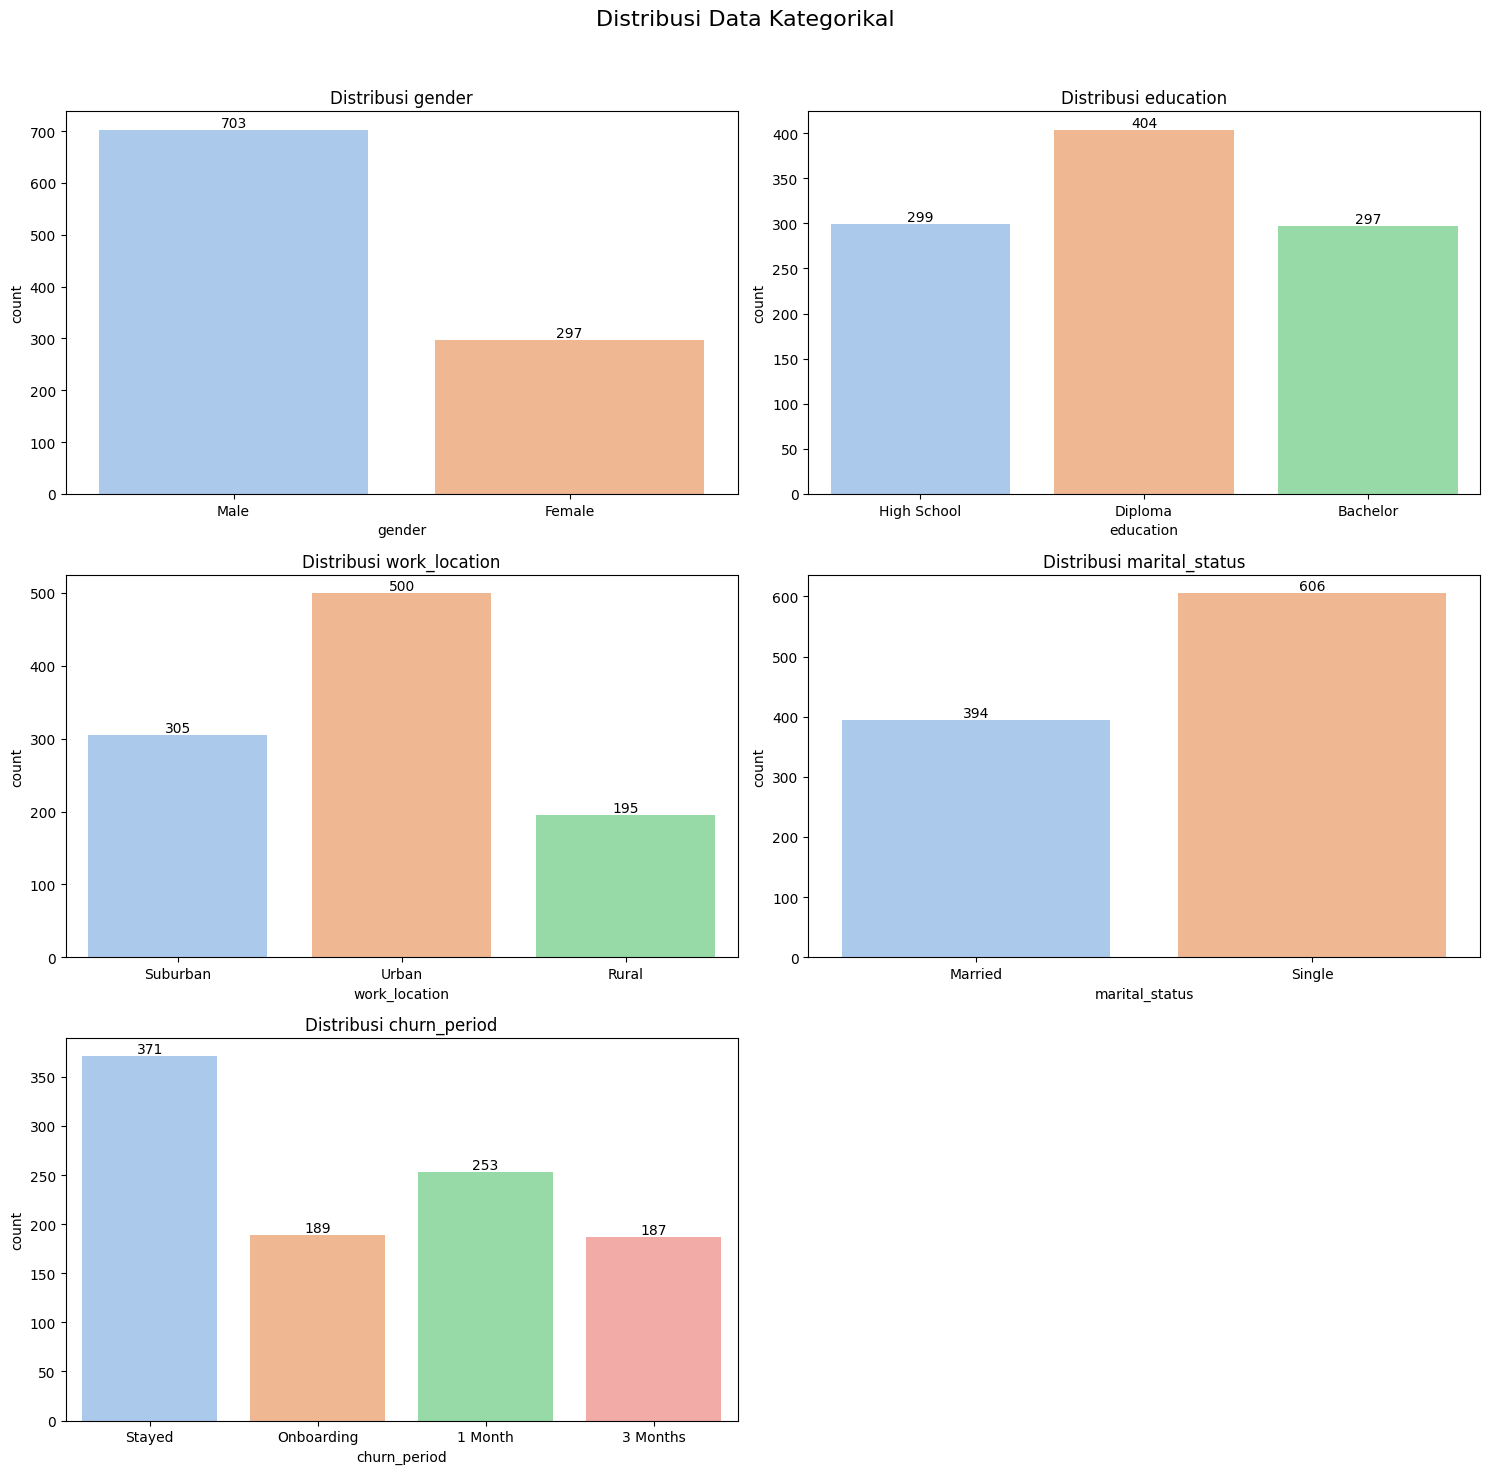

In [18]:
## Visualisasi distribusi variabel kategorikal
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Menyesuaikan jumlah baris dan kolom subplot agar cukup untuk semua kategori
n_cols = 2  # Jumlah kolom subplot
n_rows = (len(cat_cols) + 1) // n_cols  # Menentukan jumlah baris berdasarkan jumlah kategori

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
fig.suptitle("Distribusi Data Kategorikal", fontsize=16)

# Flatten axes jika hanya ada satu baris agar tidak terjadi error
axes = axes.flatten() if n_rows > 1 else np.array([axes]).flatten()

for i, col in enumerate(cat_cols):
    ax = sns.countplot(data=df, x=col, palette="pastel", ax=axes[i])
    axes[i].set_title(f"Distribusi {col}", fontsize=12)
    axes[i].set_xticklabels(axes[i].get_xticklabels())
    for cont in ax.containers:
      ax.bar_label(cont)

# Sembunyikan subplot kosong jika jumlah kategori ganjil
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



### 📦 Cek Outliers via Boxplot (Univariate Analysis)

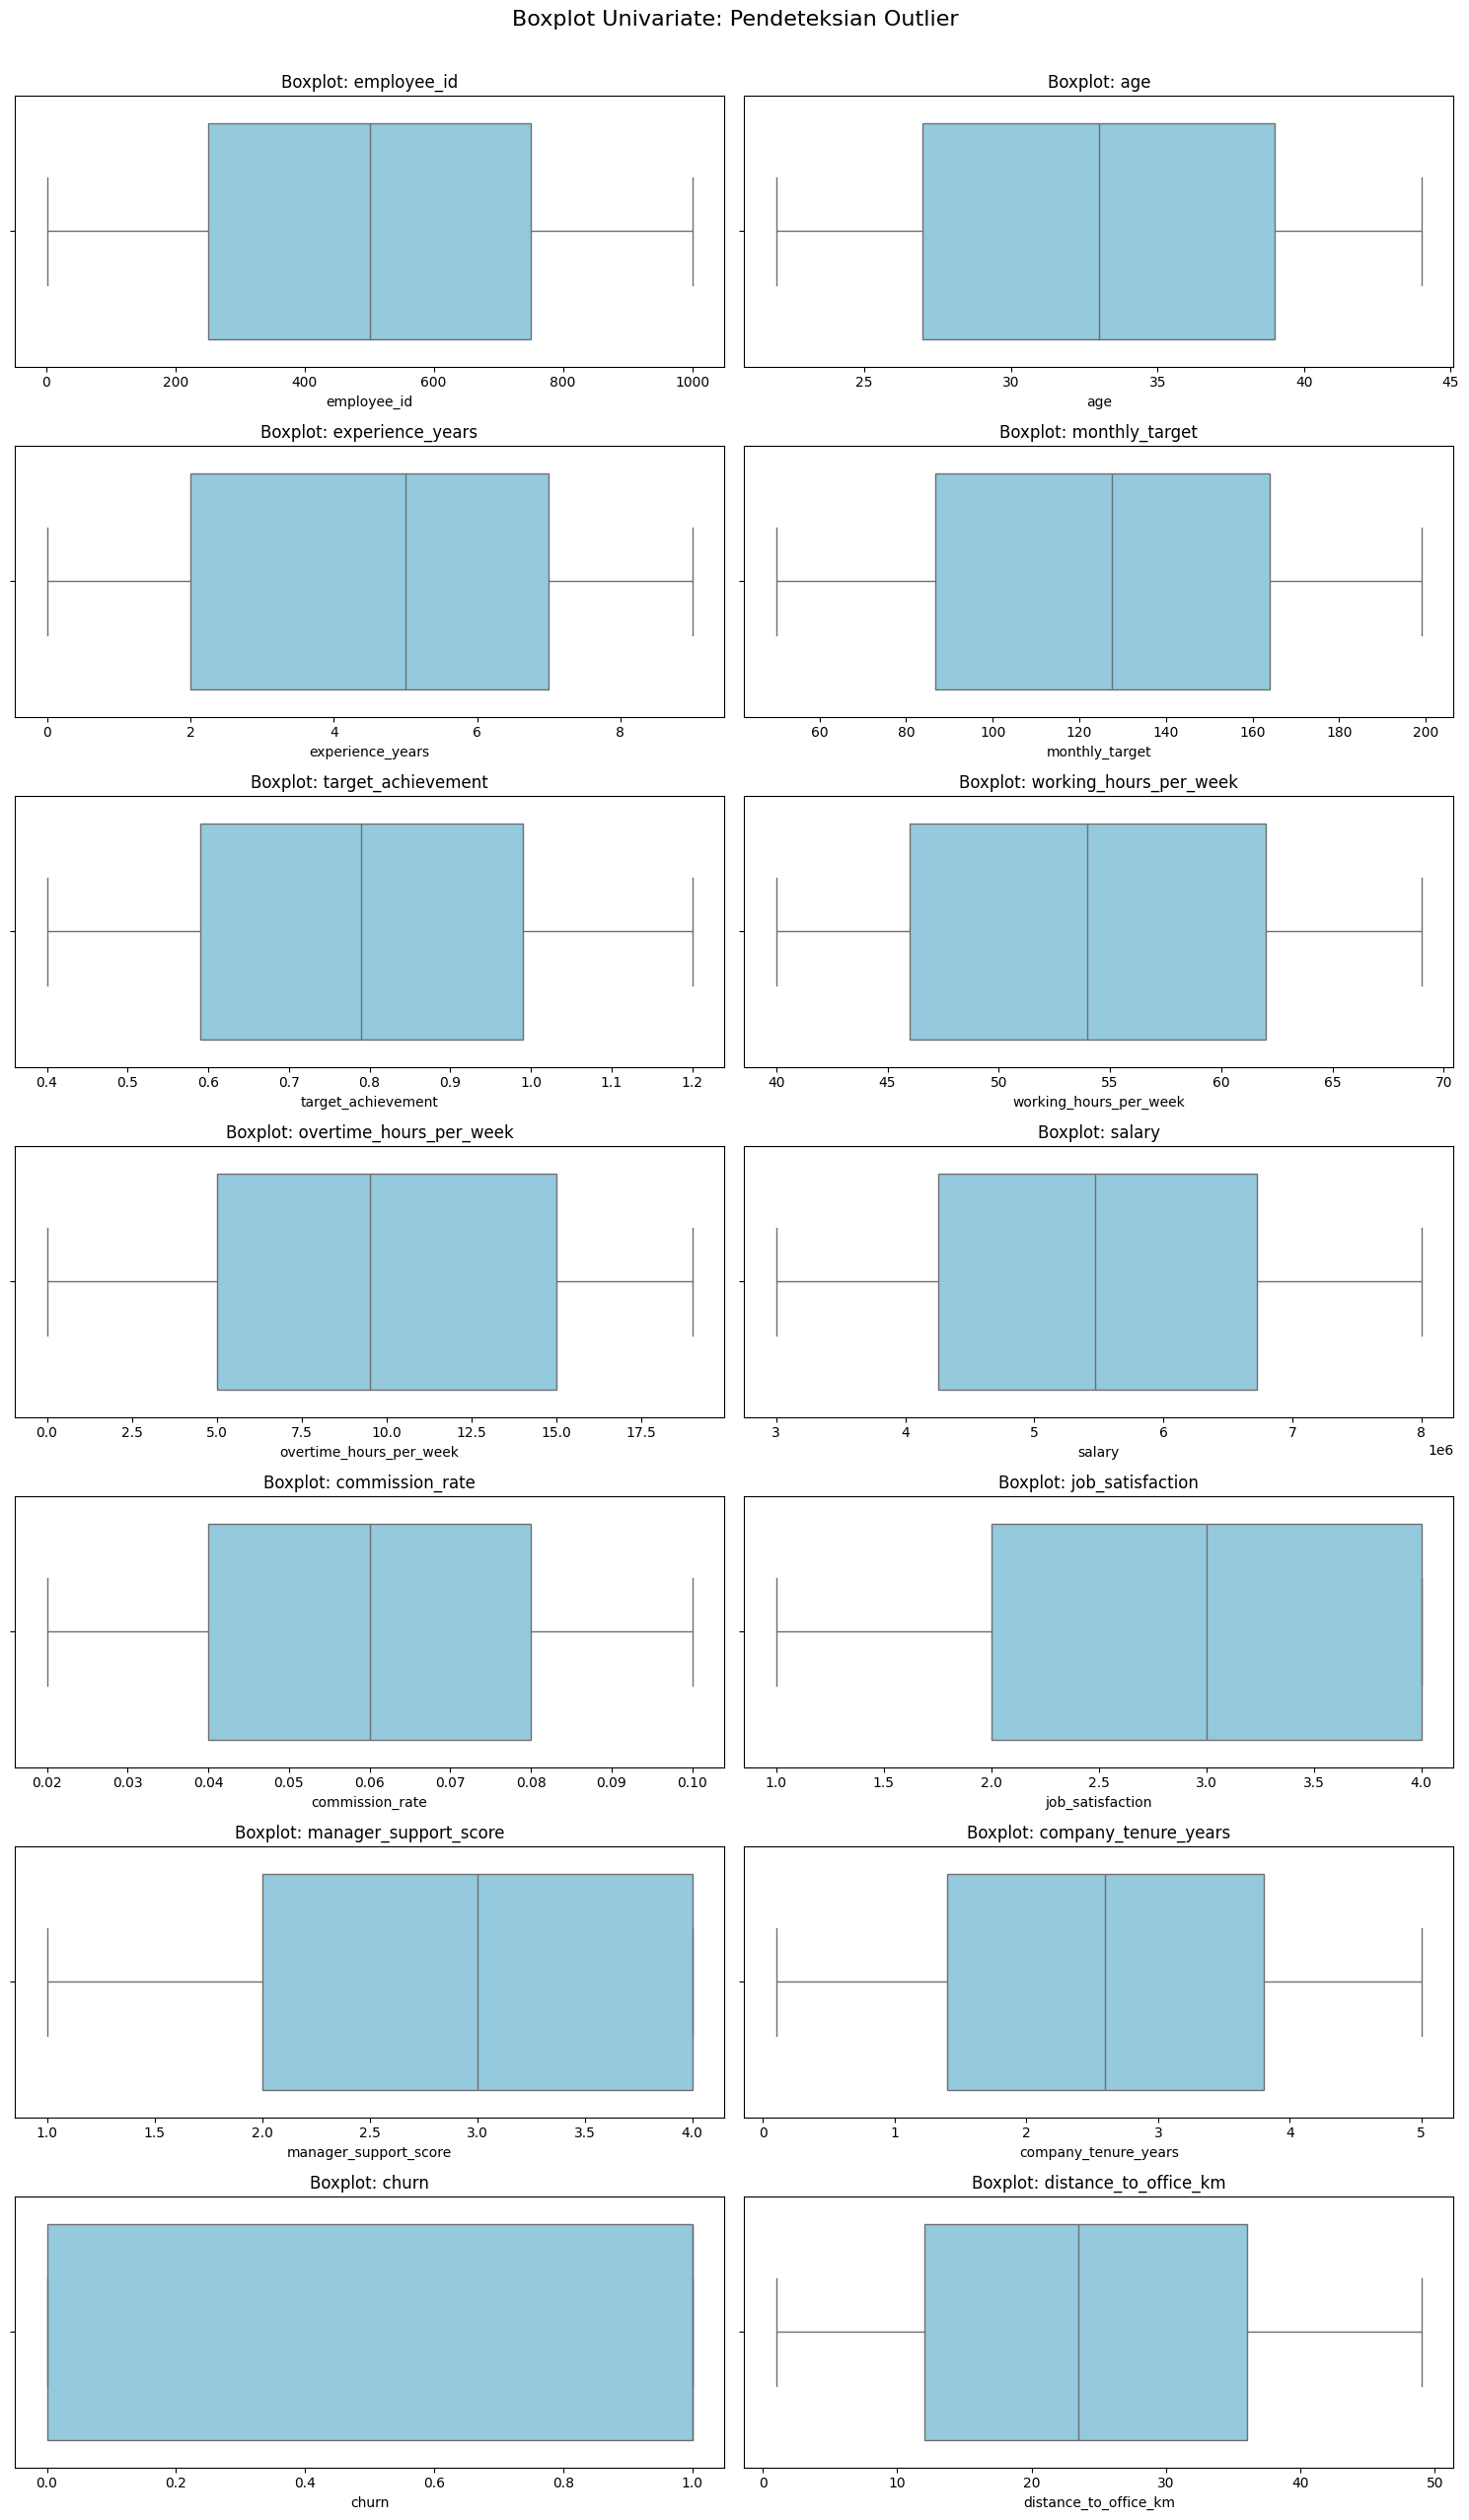

In [19]:
# Visualisasi Boxplot tiap fitur numerik
fig, axes = plt.subplots(nrows=len(num_cols)//2 + len(num_cols)%2, ncols=2, figsize=(15, 25))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot: {col}", fontsize=12)

# Hapus sisa subplot kosong jika jumlah fitur ganjil
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Boxplot Univariate: Pendeteksian Outlier", fontsize=16, y=1.02)
plt.show()

### 🔗 Multivariate Analysis

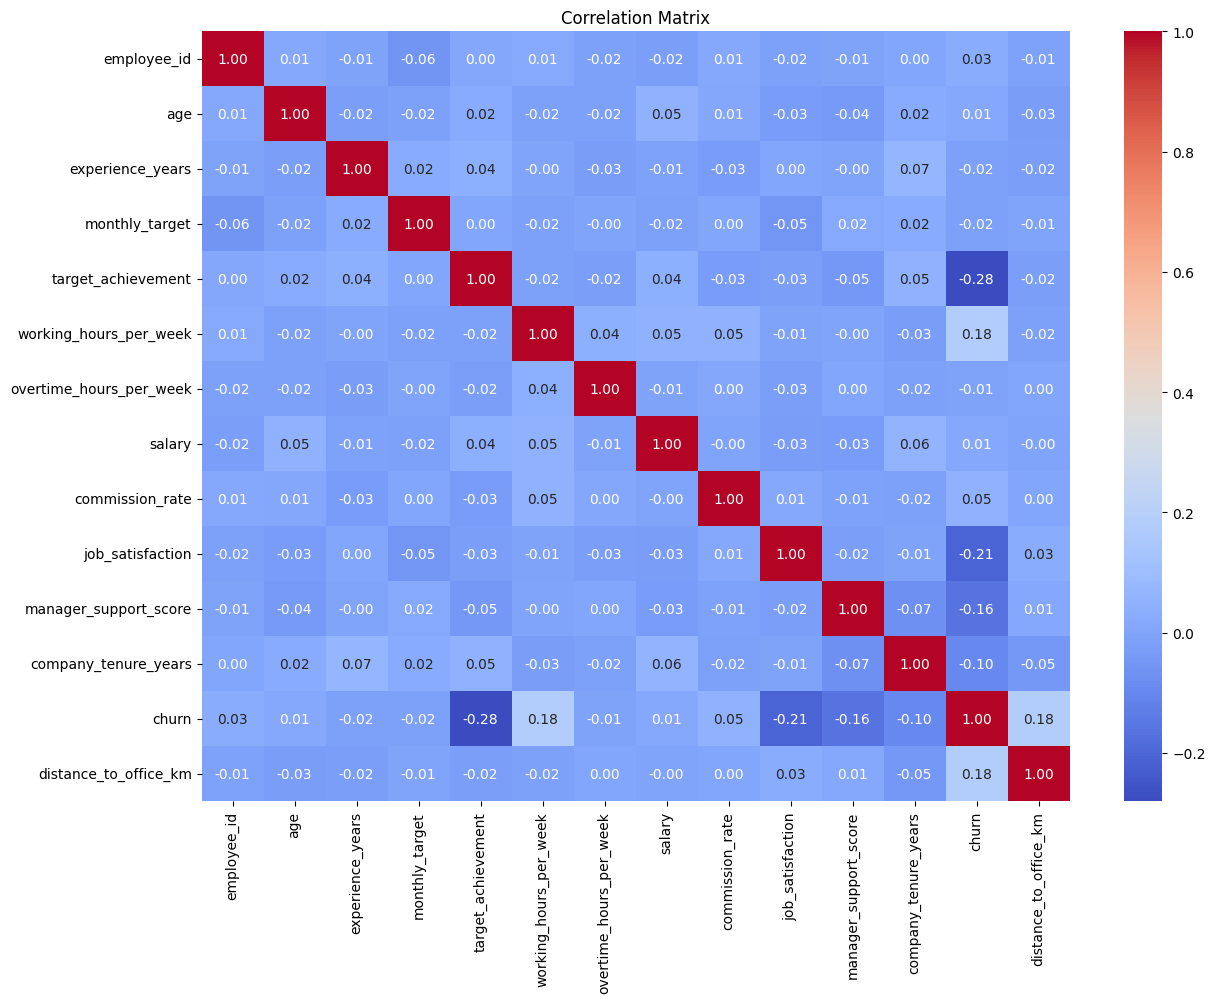

In [20]:
# Korelasi antar fitur numerik
plt.figure(figsize=(14,10))
sns.heatmap(df_cleaned[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### 🔗 Multivariate Analysis: Korelasi Antar Fitur Numerik

**🔍 Tujuan Analisis:**
Untuk memahami hubungan antar fitur numerik dan mengidentifikasi **faktor-faktor yang paling berkorelasi dengan churn**, baik secara positif maupun negatif.

---

### ✅ Hasil Pemeriksaan Korelasi:
- Korelasi dihitung menggunakan matriks korelasi Pearson.
- Sebagian besar fitur memiliki korelasi rendah satu sama lain, menunjukkan **tidak ada multikolinearitas kuat**.
- Fokus utama adalah korelasi terhadap variabel **`churn`**.

---

### 📌 Insight Utama terhadap `churn`:

| Fitur                   | Korelasi   | Interpretasi                                                                 |
|------------------------|------------|------------------------------------------------------------------------------|
| `target_achievement`   | **-0.28**  | Semakin rendah pencapaian target, semakin besar kemungkinan karyawan churn. |
| `job_satisfaction`     | **-0.21**  | Ketidakpuasan kerja berkontribusi signifikan terhadap churn.                |
| `manager_support_score`| **-0.16**  | Rendahnya dukungan dari manajer terkait dengan kemungkinan karyawan keluar. |
| `working_hours_per_week` | **+0.18** | Jam kerja yang tinggi sedikit berhubungan dengan churn.                     |
| `distance_to_office_km`  | **+0.18** | Jarak tempat tinggal ke kantor juga punya pengaruh ke churn.                |

---

### 🎯 Kesimpulan:
- Fitur yang berkorelasi negatif terhadap churn seperti `target_achievement`, `job_satisfaction`, dan `manager_support_score` **berpotensi sebagai variabel penting dalam pemodelan prediktif churn**.
- Insight ini juga mendukung pentingnya strategi **employee engagement dan support system** dalam mengurangi churn.


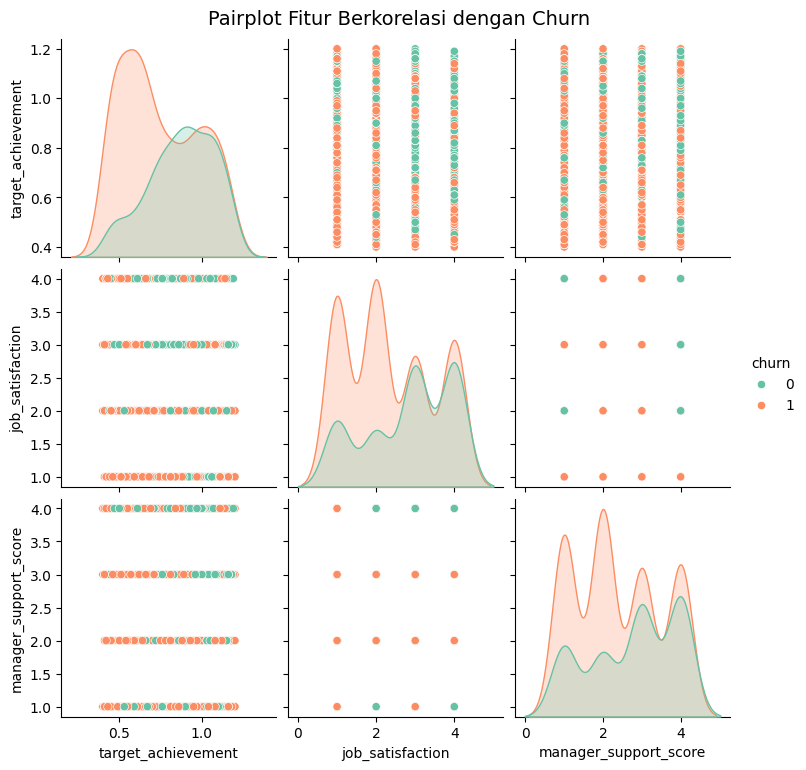

In [21]:
# Visualisasi hubungan antar fitur yang berkorelasi tinggi dengan churn
# Menggunakan pairplot untuk melihat pola antar variabel numerik terhadap churn


selected_cols = ['target_achievement', 'job_satisfaction', 'manager_support_score', 'churn']
sns.pairplot(df_cleaned[selected_cols], hue='churn', palette='Set2')
plt.suptitle("Pairplot Fitur Berkorelasi dengan Churn", fontsize=14, y=1.02)
plt.show()



### 🔍 Pairplot Fitur yang Berkaitan dengan Churn

**🎯 Tujuan:**
Mengeksplorasi hubungan visual antara **`churn`** dan tiga fitur yang paling berkorelasi dengannya, yaitu:
- `target_achievement`
- `job_satisfaction`
- `manager_support_score`

---

### ✅ Insight dari Pairplot:

- **`target_achievement`**  
  → Terlihat bahwa sebagian besar karyawan yang churn (warna oranye) memiliki pencapaian target yang **lebih rendah** dibandingkan yang tidak churn.

- **`job_satisfaction`**  
  → Karyawan yang churn cenderung memiliki tingkat kepuasan kerja **lebih rendah (nilai 1–2)** dibanding yang bertahan (yang lebih merata atau cenderung ke nilai 3–4).

- **`manager_support_score`**  
  → Distribusi churn juga lebih tinggi pada karyawan dengan **dukungan manajer yang rendah**, mendukung insight bahwa **lingkungan kerja berperan besar dalam retensi**.

---

### 📌 Kesimpulan:
Visualisasi ini memperkuat hasil korelasi bahwa fitur `target_achievement`, `job_satisfaction`, dan `manager_support_score` merupakan indikator kuat churn, dan sangat relevan untuk **pemodelan prediktif maupun rekomendasi strategis HR**.


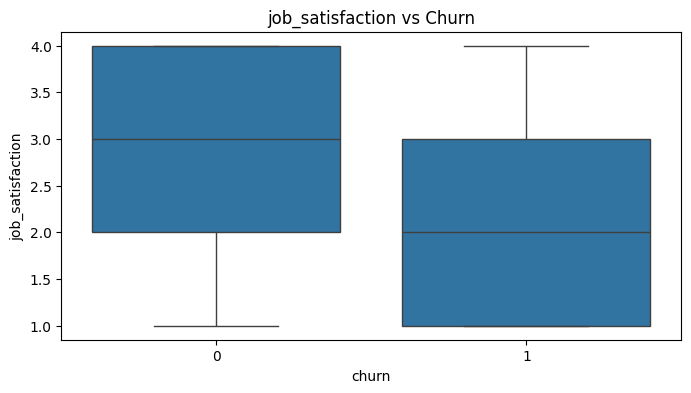

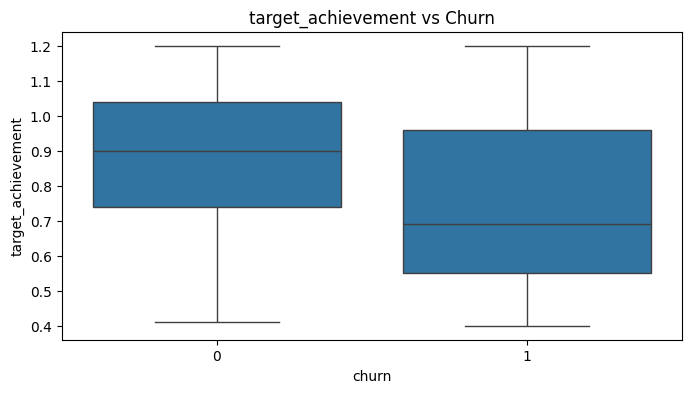

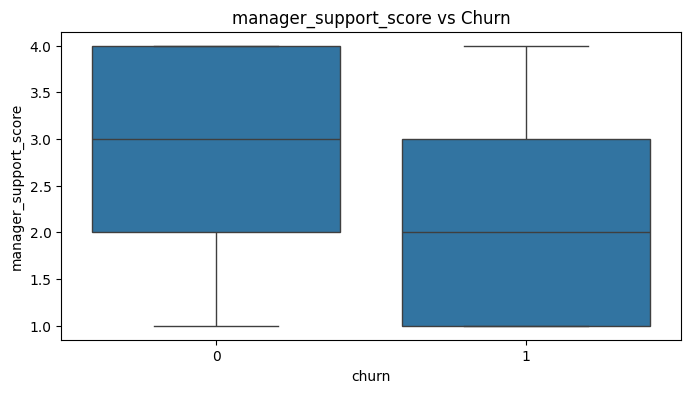

In [22]:
# Visualisasi Boxplot untuk melihat distribusi fitur penting berdasarkan status churn

# Fitur numerik yang relevan
selected_cols = ['job_satisfaction', 'target_achievement', 'manager_support_score']

for col in selected_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='churn', y=col, data=df_cleaned)
    plt.title(f'{col} vs Churn')
    plt.show()


### 📌 Penjelasan:
Boxplot ini menunjukkan **perbedaan distribusi nilai fitur numerik** antara karyawan yang churn (`churn = 1`) dan tidak churn (`churn = 0`):

- **`job_satisfaction`**  
  → Rata-rata kepuasan kerja lebih tinggi pada karyawan yang bertahan.  
  Karyawan yang churn cenderung berada pada level kepuasan kerja yang lebih rendah.

- **`target_achievement`**  
  → Karyawan yang churn memiliki pencapaian target lebih rendah secara umum.

- **`manager_support_score`**  
  → Dukungan manajer lebih tinggi pada karyawan yang tidak churn.  
  Distribusi median untuk churn terlihat lebih rendah dan padat di skor 1–2.


### 🔍 Cek Outliers Menggunakan Mahalanobis Distance

In [23]:
# Ambil fitur numerik
df_num = df_cleaned.select_dtypes(include=["number"])
X = df_num.values

# Hitung mean dan covariance matrix
mean_vec = np.mean(X, axis=0)
cov_mat = np.cov(X, rowvar=False)
inv_covmat = np.linalg.inv(cov_mat)

# Hitung Mahalanobis distance
mahal_dist = [mahalanobis(x, mean_vec, inv_covmat) for x in X]
df_cleaned["mahal_dist"] = mahal_dist

# Threshold menggunakan chi-square distribution
threshold = chi2.ppf(0.99, df_num.shape[1])  # 99% confidence, df = number of features
df_cleaned["mahal_outlier"] = df_cleaned["mahal_dist"] > np.sqrt(threshold)

# Ringkasan
print(f"Jumlah outlier (Mahalanobis): {df_cleaned['mahal_outlier'].sum()}")

Jumlah outlier (Mahalanobis): 0


## 🧹 Data Cleaning & Feature Engineering

In [24]:
df['total_hours_per_week'] = df['working_hours_per_week'] + df['overtime_hours_per_week']
df['target_ratio'] = df['target_achievement'] / (df['monthly_target'] + 1)
df = df.drop(columns=[col for col in df.columns if col.startswith("churn_period")])

Kolom churn_period perlu dihapus dikarenakan apabila dilakukan modeling pada machine learning hasilnya adalah 100% (sempurna).

In [25]:
df_encoded = pd.get_dummies(df, drop_first=True)
X = df_encoded.drop(columns=['employee_id', 'churn'])
y = df_encoded['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Standarisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 🤖 Modeling: Logistic Regression, Random Forest, XGBoost

In [27]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [28]:
# Logistic
y_pred_logreg = logreg.predict(X_test_scaled)
print("***Logistic Regression Report***")
print(classification_report(y_test, y_pred_logreg))
print("ROC AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1]))

# Random Forest
y_pred_rf = rf.predict(X_test)
print("***Random Forest Report***")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

# XGBoost
y_pred_xgb = xgb.predict(X_test)
print("***XGBoost Report***")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

***Logistic Regression Report***
              precision    recall  f1-score   support

           0       0.70      0.59      0.64        83
           1       0.74      0.82      0.78       117

    accuracy                           0.72       200
   macro avg       0.72      0.71      0.71       200
weighted avg       0.72      0.72      0.72       200

ROC AUC: 0.7956956029245186
***Random Forest Report***
              precision    recall  f1-score   support

           0       0.75      0.51      0.60        83
           1       0.72      0.88      0.79       117

    accuracy                           0.72       200
   macro avg       0.73      0.69      0.70       200
weighted avg       0.73      0.72      0.71       200

ROC AUC: 0.817320564308516
***XGBoost Report***
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        83
           1       0.76      0.85      0.80       117

    accuracy                           0.75   

📊 Hasil Evaluasi Tanpa Data Leakage (churn_period dihapus)

🔹 Logistic Regression
- Accuracy: 72%
- Precision: 74%
- Recall: 82% 👍
- F1-score: 78%
- ROC AUC: 79.6%

🔹 Random Forest
- Accuracy: 72%
- Precision: 72%
- Recall: 88% 🔥
- F1-score: 79%
- ROC AUC: 81,7%

🔹 XGBoost
- Accuracy: 75%
- Precision: 76%
- Recall: 85% 👍
- F1-score: 80%
- ROC AUC: 84.3%

💡 Insight:
Random Forest masih unggul tipis terutama dalam recall (lebih baik dalam menangkap churn).

Ini berarti model bisa cukup akurat untuk prediksi churn secara praktis, tanpa mengandalkan data yang seharusnya tidak tersedia saat prediksi dilakukan.

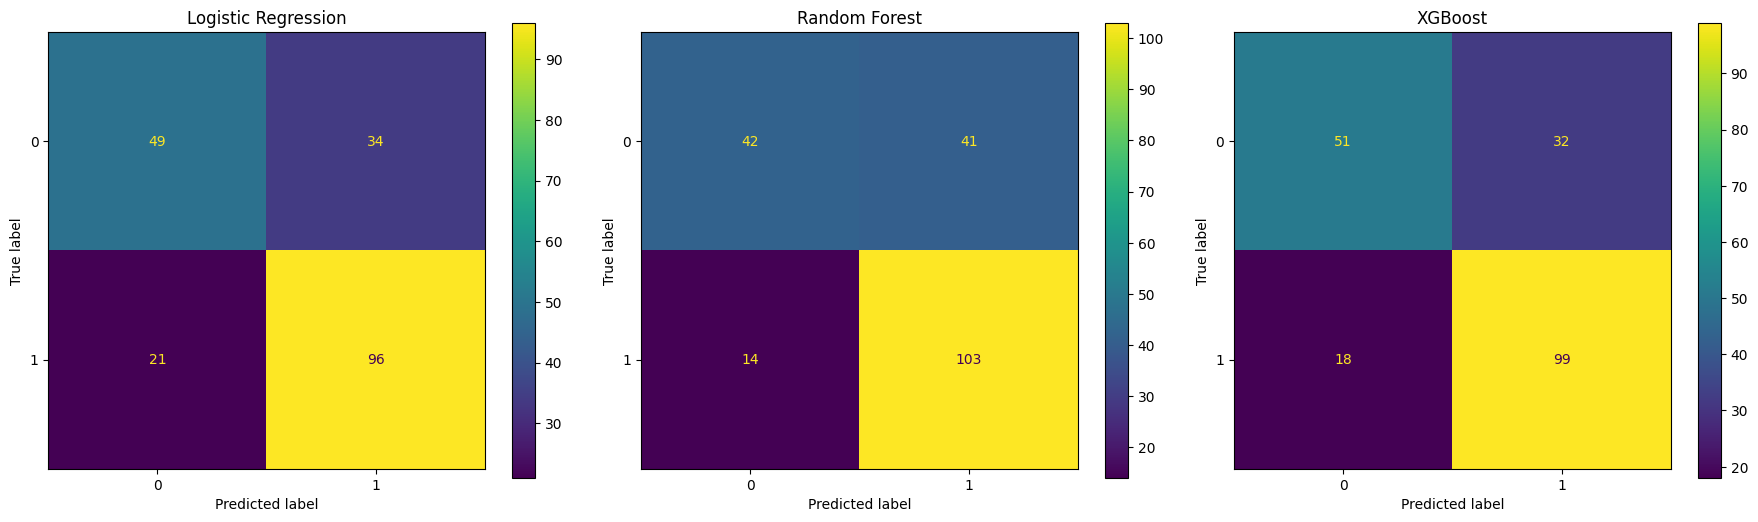

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test, ax=ax[0])
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=ax[1])
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, ax=ax[2])
ax[0].set_title("Logistic Regression")
ax[1].set_title("Random Forest")
ax[2].set_title("XGBoost")
plt.tight_layout()
plt.show()

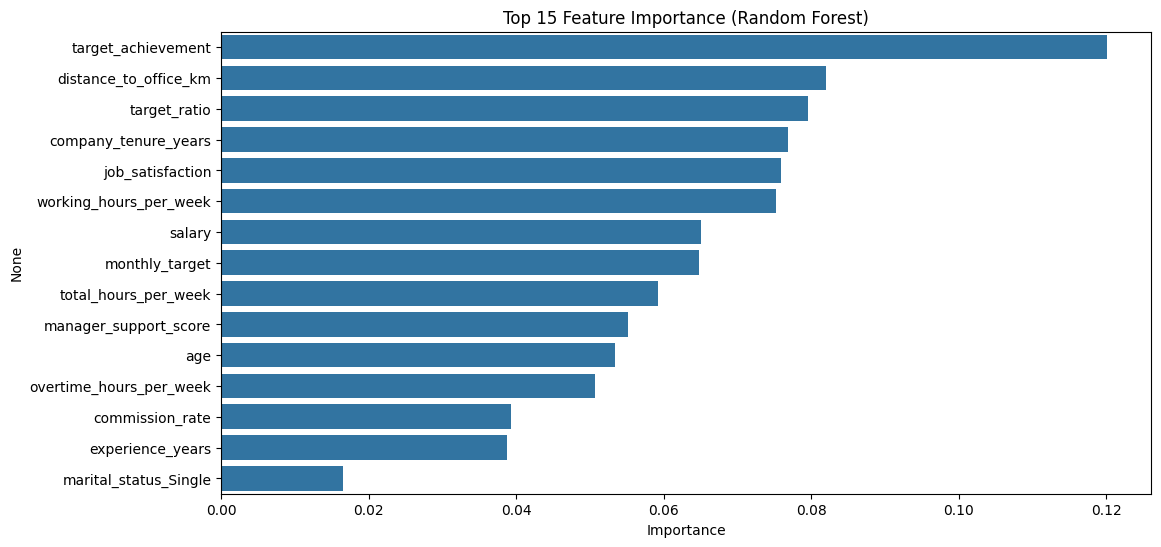

In [30]:
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
sns.barplot(x=importances[indices[:15]], y=features[indices[:15]])
plt.title("Top 15 Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [31]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

## 📌 Kesimpulan

- Faktor yang paling berkontribusi terhadap churn adalah: `target_achievement`, `job_satisfaction`, dan `manager_support_score`.
- Model dengan performa terbaik adalah **Random Forest**.
- Data leakage berhasil dihindari dengan menghapus fitur `churn_period`.

**Langkah selanjutnya:**
- Penerapan model ini ke data karyawan baru.
- Pembuatan dashboard analitik untuk tim HR.
- Interpretasi model lebih lanjut menggunakan SHAP.

## 💾 Export Cleaned Dataset

In [32]:
# Simpan dataset yang telah dibersihkan setelah outlier removal
df_cleaned.to_csv('cleaned_employee_churn.csv', index=False)
df_cleaned.head()

,employee_id,age,gender,education,experience_years,monthly_target,target_achievement,working_hours_per_week,overtime_hours_per_week,salary,...,job_satisfaction,work_location,manager_support_score,company_tenure_years,churn,marital_status,distance_to_office_km,churn_period,mahal_dist,mahal_outlier
0,1,28,Male,High School,0,153,0.94,62,9,4667108,...,4,Suburban,3,2.8,0,Married,22,Stayed,3.550651,False
1,2,41,Male,Diploma,6,188,0.54,55,8,5853507,...,3,Urban,3,2.7,1,Single,36,Onboarding,3.063356,False
2,3,36,Female,High School,8,159,0.44,59,10,4781336,...,1,Urban,2,1.7,1,Single,17,Onboarding,3.373109,False
3,4,32,Male,Diploma,7,185,0.66,68,15,3624588,...,1,Urban,2,0.5,1,Married,32,Onboarding,3.959809,False
4,5,29,Female,High School,7,142,1.01,45,9,5154327,...,3,Rural,2,4.5,0,Single,14,Stayed,3.139708,False


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['employee_id'].plot(kind='hist', bins=20, title='employee_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['experience_years'].plot(kind='hist', bins=20, title='experience_years')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('education').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('work_location').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('marital_status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='employee_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='employee_id', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='age', y='experience_years', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='experience_years', y='monthly_target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('education')):
  _plot_series(series, series_name, i)
  fig.legend(title='education', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('work_location')):
  _plot_series(series, series_name, i)
  fig.legend(title='work_location', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('marital_status')):
  _plot_series(series, series_name, i)
  fig.legend(title='marital_status', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['employee_id'].plot(kind='line', figsize=(8, 4), title='employee_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['experience_years'].plot(kind='line', figsize=(8, 4), title='experience_years')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['education'].value_counts()
    for x_label, grp in _df_20.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('education')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['work_location'].value_counts()
    for x_label, grp in _df_21.groupby('education')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('education')
_ = plt.ylabel('work_location')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['marital_status'].value_counts()
    for x_label, grp in _df_22.groupby('work_location')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('work_location')
_ = plt.ylabel('marital_status')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['churn_period'].value_counts()
    for x_label, grp in _df_23.groupby('marital_status')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('marital_status')
_ = plt.ylabel('churn_period')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['education'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='index', y='education', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['work_location'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='index', y='work_location', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['marital_status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='index', y='marital_status', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## 📌 Key Insights


- Karyawan dengan **kepuasan kerja rendah** dan **dukungan manajer yang minim** memiliki kemungkinan churn lebih tinggi.
- **Target pencapaian** yang rendah sangat berkorelasi dengan churn.
- Beberapa fitur numerik menunjukkan adanya outlier, namun sudah dibersihkan menggunakan metode IQR.

## 💼 Business Recommendations


1. **Tingkatkan kepuasan kerja** dengan program employee engagement, fleksibilitas kerja, dan pengakuan kinerja.
2. **Pelatihan dan pengembangan manajer** agar mampu memberi dukungan lebih besar kepada bawahannya.
3. Fokus pada **monitoring karyawan dengan pencapaian rendah** agar bisa diberi bantuan atau intervensi dini.
4. Gunakan model churn prediction ini untuk **mengidentifikasi risiko churn secara proaktif** dan membuat rencana retensi.
